In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [83]:
df = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')

In [84]:
df.shape

(299, 13)

In [85]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [116]:
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

### Проверим влияние номинативных НП на ЗП

In [86]:
total = df.DEATH_EVENT.count()
total_death = df[df.DEATH_EVENT == 1]['DEATH_EVENT'].count()
total_live = df[df.DEATH_EVENT == 0]['DEATH_EVENT'].count()

print('Процент произошедших сердечных приступов среди всех наблюдений: {:.2%}' \
      .format(total_death / total))

Процент произошедших сердечных приступов среди всех наблюдений: 32.11%


In [87]:
compare = {}

for illness in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']:
    death = df.loc[(df.DEATH_EVENT == 1) & (df[illness] == 1), 'DEATH_EVENT'] \
        .count() / total_death
    live = df.loc[(df.DEATH_EVENT == 0) & (df[illness] == 1), 'DEATH_EVENT'] \
        .count() / total_live

    compare['Процент умерших, имевших {}.'.format(illness)] = '{:.2%}'.format(death)
    compare['Процент живых, имевших {}.'.format(illness)] = '{:.2%}'.format(live)
    
compare

{'Процент умерших, имевших anaemia.': '47.92%',
 'Процент живых, имевших anaemia.': '40.89%',
 'Процент умерших, имевших diabetes.': '41.67%',
 'Процент живых, имевших diabetes.': '41.87%',
 'Процент умерших, имевших high_blood_pressure.': '40.62%',
 'Процент живых, имевших high_blood_pressure.': '32.51%',
 'Процент умерших, имевших sex.': '64.58%',
 'Процент живых, имевших sex.': '65.02%',
 'Процент умерших, имевших smoking.': '31.25%',
 'Процент живых, имевших smoking.': '32.51%'}

### Проверим на корреляцию и влияние на результат остальных переменных

In [88]:
df_notbool = pd.DataFrame(index=df.index)

for i in range(len(df.columns)):
    if df.iloc[:, i].nunique() > 2:
        df_notbool = df_notbool.join(df.iloc[:, i])
        
df_notbool = df_notbool.join(df.DEATH_EVENT).drop(['time'], axis=1)

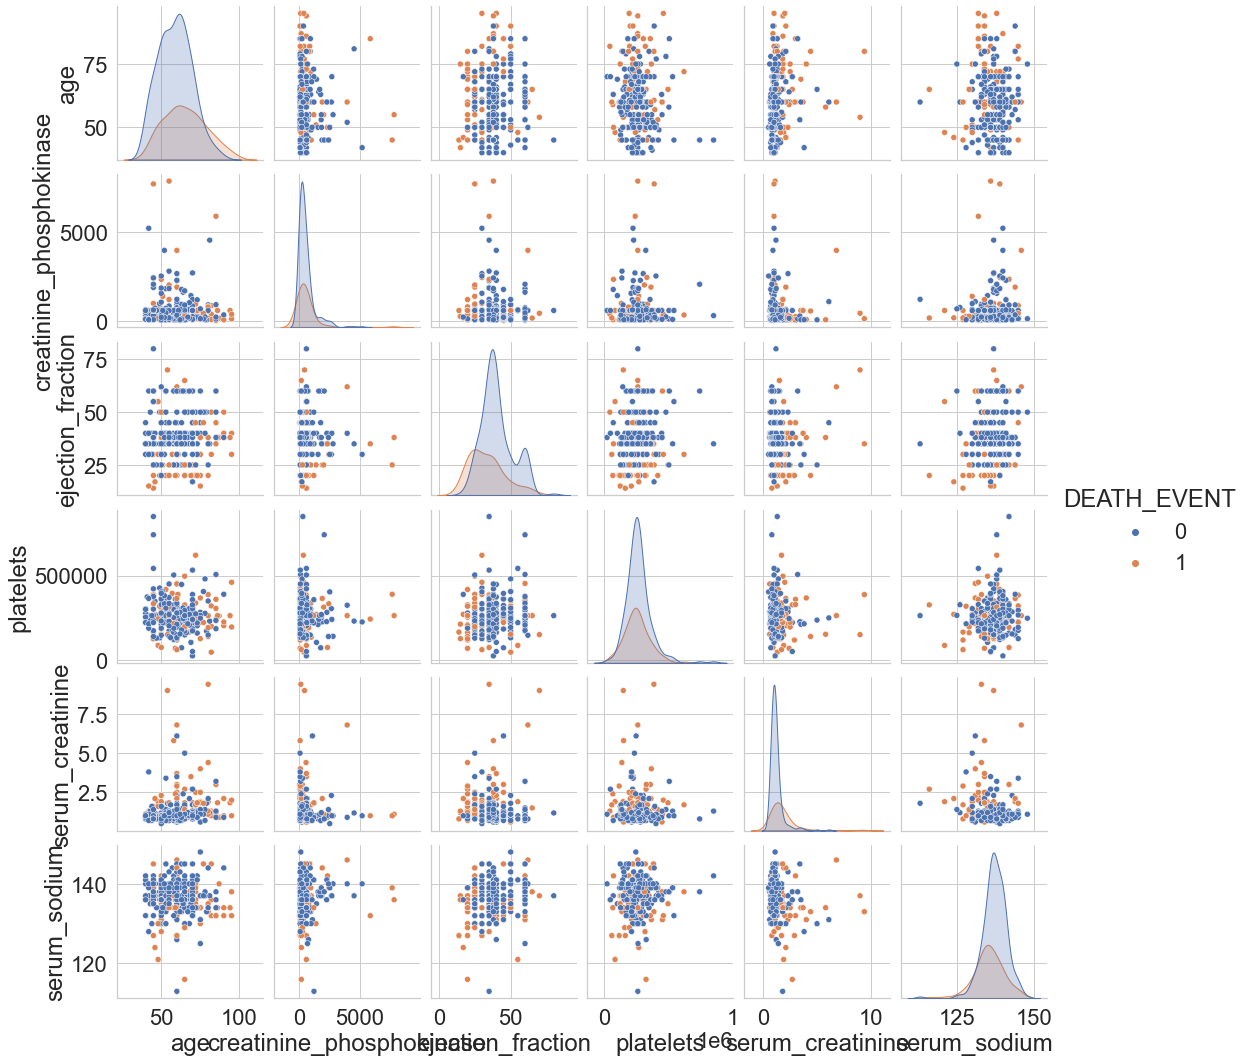

In [89]:
sns.pairplot(data=df_notbool, hue='DEATH_EVENT') 

### Разбиваем данные на train & test
Удаляем столбец time, т.к. определять болезнь нужно сразу, а не спустя месяц наблюдений.
И столбцы diabetes, sex, smoking, как невлияющие на результат.

In [117]:
df = df.drop(['time', 'diabetes', 'sex', 'smoking'], axis=1)
x = df.drop(['DEATH_EVENT'], axis=1)
y = df.DEATH_EVENT

KeyError: "['time' 'diabetes' 'sex' 'smoking'] not found in axis"

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
    train_size=0.7, shuffle=True, stratify=y)

### Масштабирование данных (стандартизация)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)
y_train = np.array(y_train)

# Применение RandomForest
Оценка точности по recall, т.к. важно выявить всех предрасположенных к сердечному приступу

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### RF без настройки

In [ ]:
clf = RandomForestClassifier()

clf.fit(x_train_scaled, y_train)

In [ ]:
y_predict_clf = clf.predict(x_train_scaled)

recall_score(y_train, y_predict_clf)

In [ ]:
y_predict_test_clf = clf.predict(x_test_scaled)

recall_score(y_test, y_predict_test_clf)

### Влияние переменных на DEATH_EVENT

In [ ]:
clf.feature_importances_

In [ ]:
feats = {}
for feature, importance in zip(df.columns, clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False).reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], \
            data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=35, weight = 'bold')
plt.ylabel('Features', fontsize=35, weight = 'bold')
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.title('Feature Importance', fontsize=35, weight = 'bold')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=8)
pca_test.fit(x_train_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
pca_df

### RF с настройкой

### Грубая с RandomSearch

In [ ]:
clf = RandomForestClassifier()

In [ ]:
param_dist = {'n_estimators': [300, 500, 700],
               'max_features': [4, 5, 6],
               'max_depth': [4, 8, 12],
               'min_samples_split': [25, 27, 29],
               'min_samples_leaf': [1, 3, 5],
               'criterion': ['gini', 'entropy']}
rs = RandomizedSearchCV(clf, param_dist, n_iter = 50, cv = 4, verbose = 1, n_jobs=-1, 
                        random_state=0)

In [ ]:
rs.fit(x_train_scaled, y_train)

In [ ]:
rs.best_params_

In [ ]:
y_predict_rs = rs.predict(x_train_scaled)

recall_rs_train = recall_score(y_train, y_predict_rs)
recall_rs_train

In [118]:
rs.score(x_train_scaled, y_train)

0.8117154811715481

In [119]:
y_predict_test_rs = rs.predict(x_test_scaled)

recall_rs_test = recall_score(y_test, y_predict_test_rs)
recall_rs_test

0.631578947368421

In [120]:
rs.score(x_test_scaled, y_test)

0.7833333333333333

### Какие параметры прорабатывал RandomSearch

In [121]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 
            'split0_test_score', 'split1_test_score', 'split2_test_score', 
            'split3_test_score', 'std_test_score'], axis=1)
rs_df.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,mean_test_score,rank_test_score
0,500,29,3,6,12,gini,0.752825,1
1,700,25,1,6,16,gini,0.748729,2
2,500,25,3,6,8,gini,0.748658,3
3,500,29,3,5,16,gini,0.744562,4
4,300,25,1,6,8,gini,0.744562,4


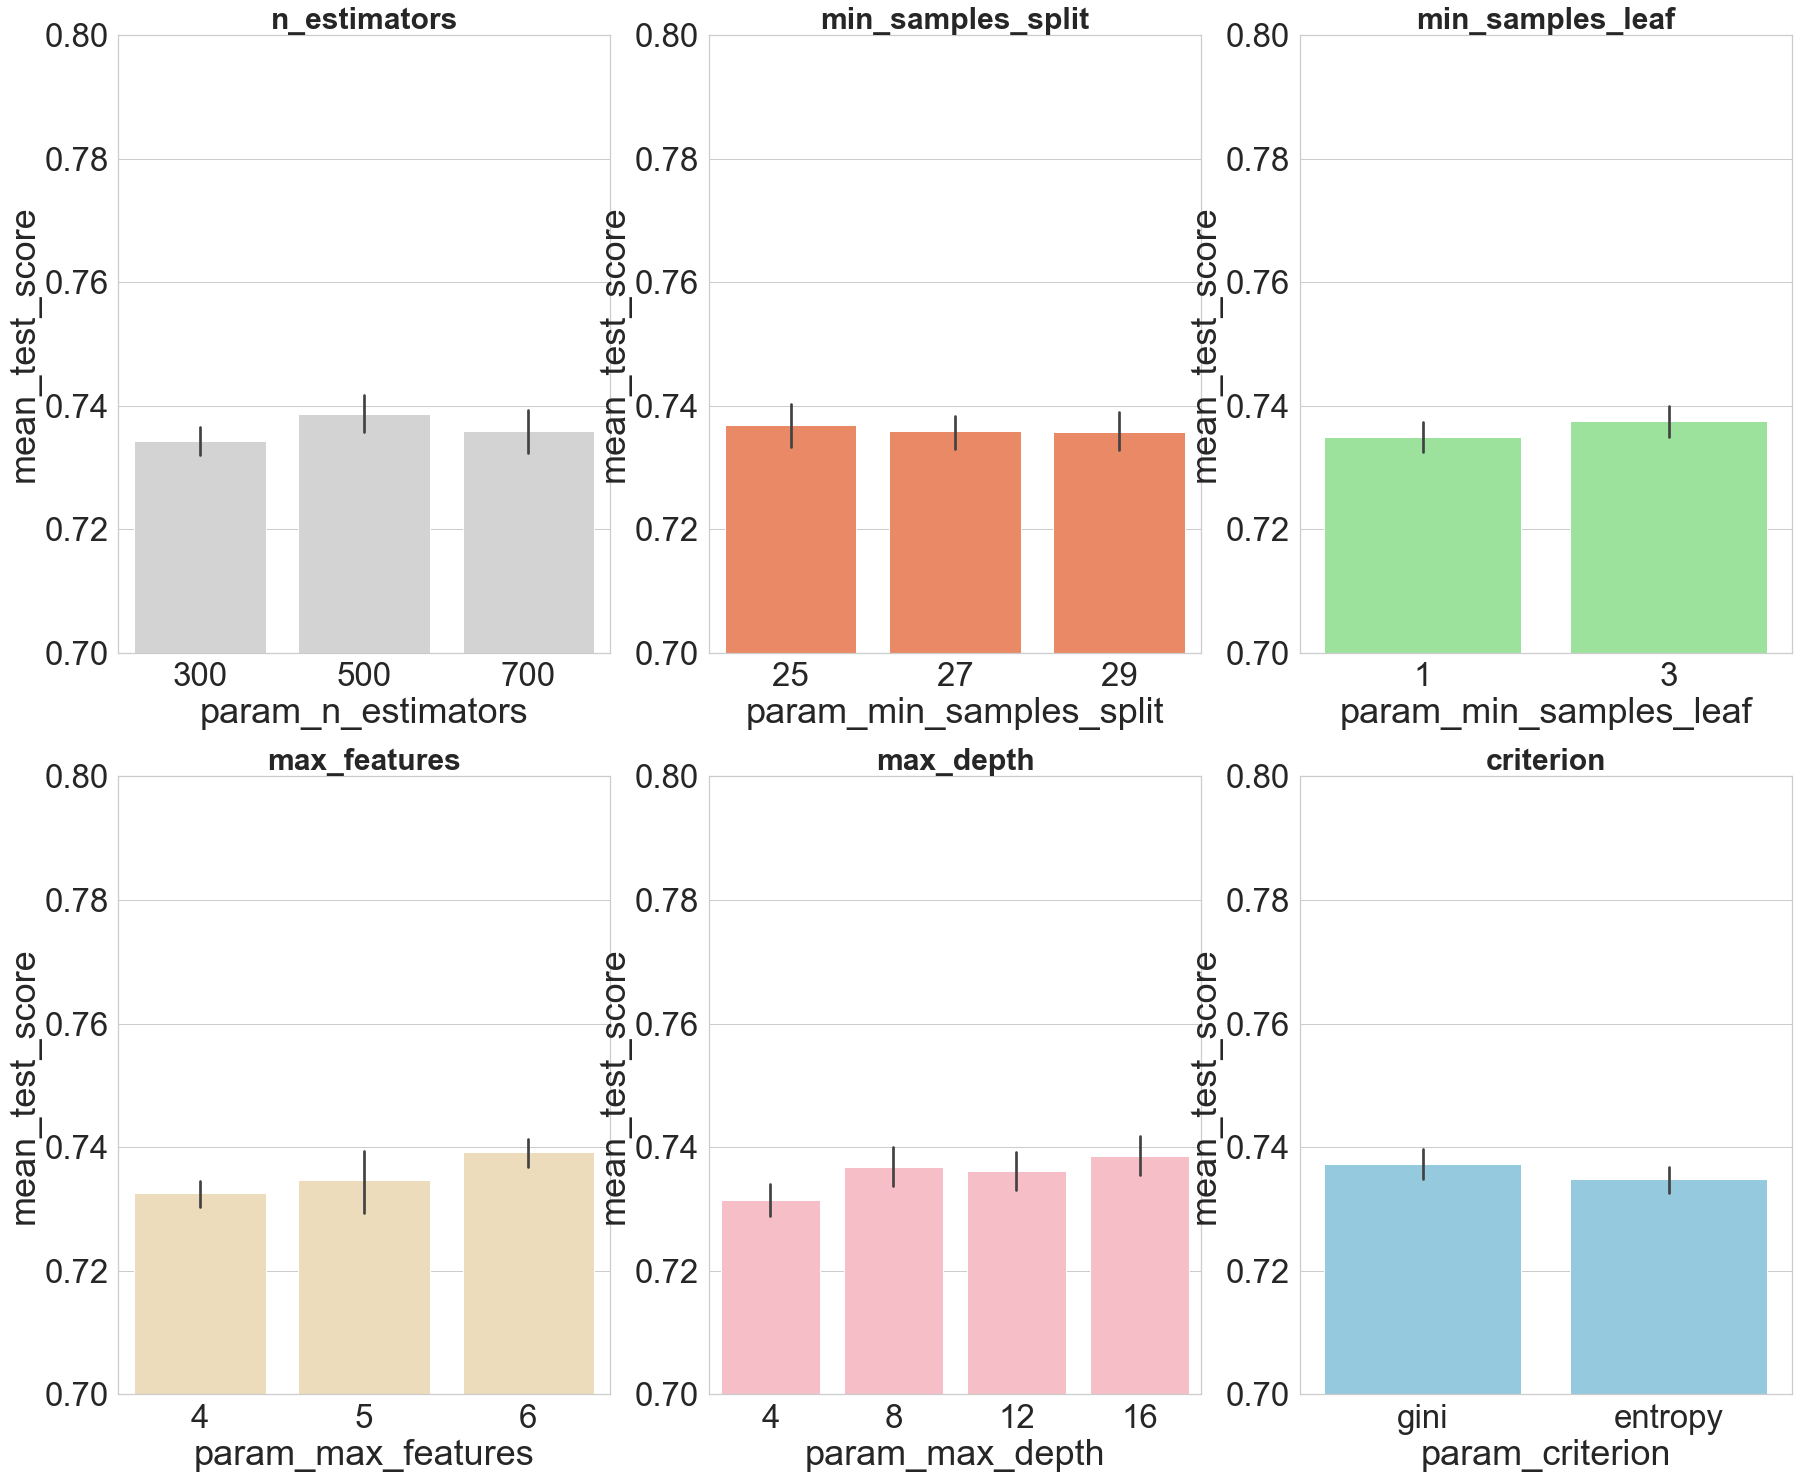

In [160]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.7,.8])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.7,.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.7,.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.7,.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.7,.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_criterion',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.7,.8])
axs[1,2].set_title(label = 'criterion', size=30, weight='bold')
plt.show()

### Точная с GridSearch

In [168]:
param_dist = {'n_estimators': [100, 300, 500],
               'max_features': [5, 6, 7],
               'max_depth': [6, 8, 10],
               'min_samples_split': [25],
               'min_samples_leaf': [1, 2],
               'criterion': ['gini']}
gs = GridSearchCV(clf, 
                param_dist, 
                cv = 5, 
                verbose = 1, 
                n_jobs=-1)

In [169]:
gs.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.9min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [6, 8, 10],
                         'max_features': [5, 6, 7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [25],
                         'n_estimators': [100, 300, 500]},
             verbose=1)

In [170]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 25,
 'n_estimators': 100}

In [171]:
y_predict_gs = gs.predict(x_train_scaled)

recall_gs_train = recall_score(y_train, y_predict_gs)
recall_gs_train

0.7402597402597403

In [172]:
y_predict_test_gs = gs.predict(x_test_scaled)

recall_gs_test = recall_score(y_test, y_predict_test_gs)
recall_gs_test

0.5263157894736842

### Сравнение оценок recall для RandomSearch & GridSearch

In [173]:
recall_comparison = pd.DataFrame([[recall_rs_train, recall_rs_test], \
    [recall_gs_train, recall_gs_test]], columns=['train', 'test'], index=['RandomSearch', \
    'GridSearch'])

In [174]:
recall_comparison

,train,test
RandomSearch,0.753247,0.631579
GridSearch,0.740260,0.526316


### Recall у более точного GridSearch выше. Но оценки все равно низкие. Основная причина, предположительно, малый размер выборки (300 наблюдений).